In [1]:
%pylab inline

import pandas as pd
import pickle

# NLP
import gensim
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from spellchecker import SpellChecker

from tqdm._tqdm_notebook import tqdm_notebook

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
# import os
# os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

Populating the interactive namespace from numpy and matplotlib


In [47]:
import itertools

In [4]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
logging.disable()

In [5]:
tqdm_notebook.pandas()

In [6]:
data = pd.read_csv('twitter.csv', encoding='ISO-8859-1', names=['target', 'ids', 'date', 'flag', 'user', 'text'])

In [7]:
data.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [8]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
data.target = data.target.apply(lambda x: decode_map[int(x)])

In [9]:
clean_regex = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [10]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")
spell = SpellChecker()

def preprocess(text, stem=False, correct=False):
    # Remove link, user, and special characters
    text = re.sub(clean_regex, ' ', str(text).lower()).strip()
    tokens = []
    text_arr = text.split()
    if correct:
        unknown = list(spell.unknown(text_arr))
    for token in text_arr:
        if token not in stop_words:
            if correct and token in unknown:
                token = spell.correction(token)
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return ' '.join(tokens)

In [11]:
%%time
data.text = data.text.progress_apply(lambda text: preprocess(text, stem=False, correct=False))


CPU times: user 57.1 s, sys: 1.68 s, total: 58.8 s
Wall time: 1min 1s


In [12]:
df_train, df_test = train_test_split(data, test_size=0.20)

In [13]:
%%time
documents = list(df_train.text.progress_apply(lambda text: text.split()))


CPU times: user 4.85 s, sys: 321 ms, total: 5.17 s
Wall time: 5.34 s


In [14]:
# Setup word2vector model
w2v_model = gensim.models.word2vec.Word2Vec(size=300, window=32, min_count=10, workers=8)
w2v_model.build_vocab(documents)

words = w2v_model.wv.vocab.keys()
print("Vocab size", len(words))

Vocab size 30430


In [15]:
w2v_model.train(documents, total_examples=len(documents), epochs=32)

(263169565, 295261984)

In [14]:
w2v_model = gensim.models.word2vec.Word2Vec.load('model.w2v')

In [15]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290637
CPU times: user 23 s, sys: 370 ms, total: 23.4 s
Wall time: 24.1 s


In [34]:
w2v_model.wv.most_similar('dog')

[('puppy', 0.6284438967704773),
 ('cat', 0.5603921413421631),
 ('dogs', 0.5430063605308533),
 ('pup', 0.514784574508667),
 ('kitty', 0.5078885555267334),
 ('doggie', 0.492411732673645),
 ('doggy', 0.4883243441581726),
 ('chihuahua', 0.47721248865127563),
 ('kitten', 0.4654090404510498),
 ('puppies', 0.46119287610054016)]

In [19]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=300)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=300)

CPU times: user 31.5 s, sys: 1.16 s, total: 32.7 s
Wall time: 34.3 s


In [20]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train", y_train.shape)
print("y_test", y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [21]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290637, 300)


In [22]:
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=300, trainable=False)

In [23]:
# Build neural network
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          87191100  
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 87,351,601
Trainable params: 160,501
Non-trainable params: 87,191,100
_________________________________________________________________


In [24]:
model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

In [25]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [26]:
class SeqGen(utils.Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))
    def __getitem__(self, idx):
        #print("Fetching batch {}".format(idx))
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

In [58]:
%%time
"""
history = model.fit(x_train, y_train, batch_size=1024, epochs=8, 
                    validation_split=0.1, verbose=1, callbacks=callbacks)
"""                    
#history = model.fit_generator(SeqGen(x_train, y_train, batch_size=1024), epochs=1, callbacks=callbacks, workers=4)
history = model.fit(x_train, y_train, batch_size=1024, epochs=1, callbacks=callbacks)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.2 µs


'\nhistory = model.fit(x_train, y_train, batch_size=1024, epochs=8, \n                    validation_split=0.1, verbose=1, callbacks=callbacks)\n'

In [39]:
# Prediction
def predict(text):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=300)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = 'negative' if score < 0.5 else 'positive'
    return {'label': label, 'score': float(score), 'elapsed_time': time.time()-start_at} 

In [40]:
# Save objects
model.save('model.h5')
w2v_model.save('model.w2v')
pickle.dump(tokenizer, open('tokenizer.obj', "wb"), protocol=0)
pickle.dump(encoder, open('encoder.obj', "wb"), protocol=0)

In [83]:
predict('hello')

{'label': 'positive',
 'score': 0.9307453632354736,
 'elapsed_time': 0.061148881912231445}

In [70]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float')[:2,2:] / cm.sum(axis=1)[:2]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

In [45]:
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = ['negative' if score < 0.50 else 'positive' for score in scores]

320000/320000 [==============================] - 409s 1ms/sample


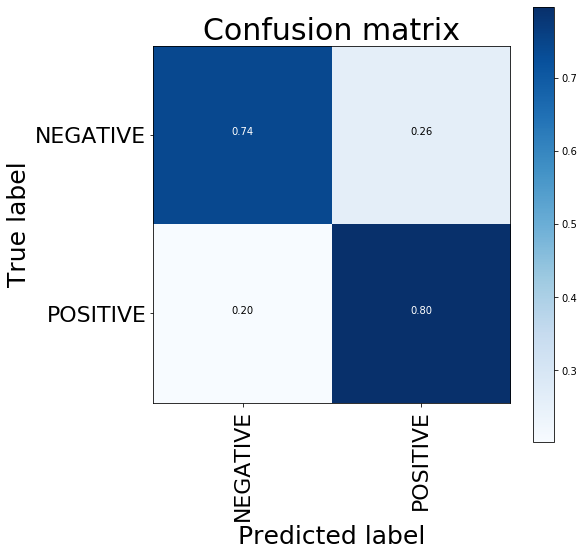

In [72]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()